# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from pathlib import Path

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction import DictVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV


from xgboost import XGBRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
import lightgbm as lgb

# Correction of planned CSV

In [10]:
# correction step for wrong year in CSVs
#  all_files = list(
#     Path("/home/antoine/projects/forecasting/data/planned flights").glob("*.csv")
# )
# col_names = ['[Arr] ELDT', '[Arr] ALDT', '[Arr] SIBT',
#        '[Arr] AIBT','[Dep] SOBT', '[Dep] AOBT', '[Dep] EDCT',
#        '[Dep] ATOT', ]
# for i,path in enumerate(all_files):
#     csv = pd.read_csv(path)
#     for col_name in col_names:
#         csv.loc[csv[col_name].notna(),col_name] = csv.loc[csv[col_name].notna(),
#             col_name
#         ].apply(lambda x: x[0:3] + "3" + x[4:])

#     csv.to_csv(Path('/home/antoine/projects/forecasting/data/planned_flight_corrected')/path.name)


# CSV Reads

In [11]:
data_airports = pd.read_csv(
    "/home/antoine/projects/forecasting/data/AODB_airport_master.csv"
)

data_countries = pd.read_csv(
    "/home/antoine/projects/forecasting/data/AODB_country_master.csv"
)

all_files = list(
    Path("/home/antoine/projects/forecasting/data/planned flights").glob("*.csv")
)
data_planned = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

all_files = list(
    Path("/home/antoine/projects/forecasting/data/KIX_AODB_data").glob("*.csv")
)
data_actual = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [12]:
pd.to_datetime(data_actual['[Dep] SOBT']).dt.date

0        2022-09-04
1        2022-09-07
2        2022-09-07
3        2022-09-07
4        2022-09-07
            ...    
43683           NaT
43684           NaT
43685           NaT
43686           NaT
43687           NaT
Name: [Dep] SOBT, Length: 43688, dtype: object

# Data cleaning & augmenting

In [29]:
def data_cleaning(data_actual, training: bool = True):
    # generate proper format
    mask = data_actual["[Dep] Flight Designator"].notna()
    data_dep = pd.DataFrame.from_dict(
        {
            "L Board Pax": pd.to_numeric(
                data_actual[mask]["[Dep]  L Board Pax"], errors="coerce"
            ).to_list(),
            "Routing-FirstLeg": data_actual[mask]["[Dep] Routing"]
            .apply(lambda x: x[-4:])
            .to_list(),
            "Datetime": pd.to_datetime(data_actual[mask]["[Dep] SOBT"]).to_list(),
            "Service Type": data_actual[mask]["[Dep] Service Type"].to_list(),
            "Traffic Type": data_actual[mask]["[Dep] Traffic Type"].to_list(),
            "UniqueID": pd.to_datetime(data_actual[mask]["[Dep] SOBT"]).dt.strftime('%Y/%m/%d')
            + " "
            + data_actual[mask]["[Dep] Flight Designator"],
            # "Capacity": pd.to_numeric(
            #     data_actual[mask]["[Dep] Capacity"], errors="coerce"
            # ).to_list(),
        }
    )
    data_dep["Direction"] = "departure"

    mask = data_actual["[Arr] Flight Designator"].notna()
    data_arr = pd.DataFrame.from_dict(
        {
            "L Board Pax": pd.to_numeric(
                data_actual[mask]["[Arr]  L Board Pax"], errors="coerce"
            ).to_list(),
            "Routing-FirstLeg": data_actual[mask]["[Arr] Routing"]
            .apply(lambda x: x[0:4])
            .to_list(),
            "Datetime": pd.to_datetime(data_actual[mask]["[Arr] SIBT"]).to_list(),
            "Service Type": data_actual[mask]["[Arr] Service Type"].to_list(),
            "Traffic Type": data_actual[mask]["[Arr] Traffic Type"].to_list(),
            "UniqueID": pd.to_datetime(data_actual[mask]["[Arr] SIBT"]).dt.strftime('%Y/%m/%d')
            + " "
            + data_actual[mask]["[Arr] Flight Designator"],
            # "Capacity": pd.to_numeric(
            #     data_actual[mask]["[Arr] Capacity"], errors="coerce"
            # ).to_list(),
        }
    )
    data_arr["Direction"] = "arrival"

    data_concat = pd.concat([data_dep, data_arr]).reset_index(drop=True)
    data_concat.drop_duplicates(subset=["UniqueID"], inplace=True)
    data = data_concat.copy()

    # select only useful columns
    data = data[
        [
            "Service Type",  # string
            "Traffic Type",  # string
            # "Capacity",  # to convert to int
            "L Board Pax",  # int already
            "Direction",  # string
            "Datetime",  # date to convert to int for year/month/date/hour
            "Routing-FirstLeg",  # string, should be country
            "UniqueID",
        ]
    ].copy()

    # filter out 26 December
    mask = data["Datetime"].dt.floor("d") != pd.to_datetime("2022-12-26").floor("d")
    data = data[mask].copy()
    # filter out rows with irrelevant values
    mask = data["Service Type"].isin(["C", "G", "J"])
    data = data[mask].copy()

    # change capacity to numerical
    # data["Capacity"] = pd.to_numeric(data["Capacity"], errors="coerce")
    data["L Board Pax"] = pd.to_numeric(data["L Board Pax"], errors="coerce")

    # split date into year month day
    data["Datetime"] = pd.to_datetime(data["Datetime"])
    data["Year"] = data["Datetime"].apply(lambda x: x.year)
    data["Month"] = data["Datetime"].apply(lambda x: x.month)
    data["Day"] = data["Datetime"].apply(lambda x: x.day)
    data["Hour"] = data["Datetime"].apply(lambda x: x.hour)
    data["LinearDate"] = (
        pd.to_datetime(data["Datetime"]) - pd.to_datetime("2022-06-01")
    ) / np.timedelta64(1, "D")

    # for training, take relevant flights and calculate LF
    if training:
        mask = data["L Board Pax"] > 10
        data = data[mask].copy()
        # data.dropna(inplace=True)
        data["L Board Pax"] = data["L Board Pax"].astype("int")
        # data["Load Factor"] = data["L Board Pax"] / data["Capacity"]
        # data = data[(data["Load Factor"]<1) & (data["Load Factor"]>0.1) ]
    else:
        data["L Board Pax"] = np.nan
    #     # mask = data["Capacity"] > 80
    #     # data = data[mask].copy()
    #     # data["Load Factor"] = np.nan

    # change routing to Country name then to Country code
    repl = (
        data_airports[["ICAO", "Country"]].set_index("ICAO").T.to_dict(orient="records")
    )
    data["Country"] = data["Routing-FirstLeg"].map(*repl)
    repl_country = (
        data_countries[["Name", "ISO-3166-1 alpha-2"]]
        .set_index("Name")
        .T.to_dict(orient="records")
    )
    data["Country"] = data["Country"].map(*repl_country)

    # holidays
    data["HolidayJP"] = 0
    data["HolidayOrigin"] = 0

    dct_holiday = {
        country_code: holidays.country_holidays(country_code)
        for country_code in data["Country"].unique()
        if hasattr(holidays, country_code)
    }

    for index, row in data.iterrows():
        # domestic holiday
        if row["Datetime"] in dct_holiday["JP"]:
            data.loc[index, "HolidayJP"] = 1
        # overseas holiday
        if row["Country"] in dct_holiday.keys():
            if row["Datetime"] in dct_holiday[row["Country"]]:
                data.loc[index, "HolidayOrigin"] = 1

    # drop old columns
    data.drop(
        [
            # "L Board Pax",
            # "Capacity",
            "Routing-FirstLeg",
            # "Datetime",
        ],
        axis="columns",
        inplace=True,
    )

    # change types for categories
    data["Service Type"] = data["Service Type"].astype("category")
    data["Traffic Type"] = data["Traffic Type"].astype("category")
    data["Direction"] = data["Direction"].astype("category")
    data["Country"] = data["Country"].astype("category")

    data["Month"] = data["Month"].astype("category")
    data["Day"] = data["Day"].astype("category")
    data["Hour"] = data["Hour"].astype("category")

    return data


# Pipeline creation and first fit

In [30]:
# pipeline creation
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)
model = XGBRegressor()
# model = LGBMRegressor()
regressor = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])


In [31]:
# data cleaning
data_actual_clean = data_cleaning(data_actual)
# split dataset
X = data_actual_clean.drop(["L Board Pax", "UniqueID", "Datetime"], axis=1)
y = data_actual_clean["L Board Pax"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

regressor.fit(X_train, y_train)
print("training score: %.3f" % regressor.score(X_train, y_train))
print("model score: %.3f" % regressor.score(X_test, y_test))


/tmp/ipykernel_527/2770104985.py:108: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  .T.to_dict(orient="records")


training score: 0.725
model score: 0.600


In [32]:
# # for lgbm
# feat_importances = pd.Series(
#     model.feature_importances_, index=regressor["preprocessor"].get_feature_names_out()
# )
# feat_importances.nlargest(10).plot(kind="barh")


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

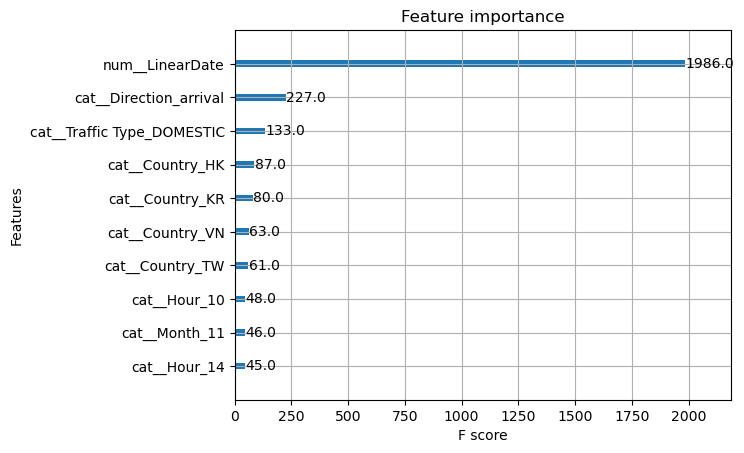

In [33]:
regressor["regressor"].get_booster().feature_names = list(
    regressor["preprocessor"].get_feature_names_out()
)
xgb.plot_importance(regressor["regressor"], ax=plt.gca(), max_num_features=10)


# Hyper-parameters tuning

In [34]:
# Set the parameters by cross-validation
hyperparameter_grid = {
    # 'regressor__n_estimators': [100, 400, 800],
    # 'regressor__max_depth': [3, 6, 9],
    "regressor__learning_rate": [0.30, 0.35, 0.5, 0.6],
    "regressor__min_child_weight": [1, 5, 10],
}

# gridCV = GridSearchCV(regressor, param_grid=hyperparameter_grid, cv=4)
# # gridCV.fit(X_train, y_train)

# print("Best parameters set found on development set:")
# print(gridCV.best_params_)
# print("Best score found on development set:")
# print(gridCV.best_score_)


In [35]:
model = XGBRegressor(learning_rate=0.5)
regressor = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])

regressor.fit(X_train, y_train)
print("training score: %.3f" % regressor.score(X_train, y_train))
print("model score: %.3f" % regressor.score(X_test, y_test))


training score: 0.766
model score: 0.591


# Test model on future schedule

In [36]:
# make predictions on January
data_forecast_clean = data_cleaning(data_planned, training=False)
X_forecast = data_forecast_clean.drop(["L Board Pax", "UniqueID", "Datetime"], axis=1)
preds = regressor.predict(X_forecast)


/tmp/ipykernel_527/2770104985.py:108: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  .T.to_dict(orient="records")


In [37]:
data_forecast_clean["L Board Pax"] = preds


In [38]:
data_actual_result = data_actual_clean.set_index("Datetime", drop=True)
mask = (data_actual_result["Traffic Type"] == "INTERNATIONAL") & (
    data_actual_result["Direction"] == "departure"
)
plot_actual = data_actual_result[mask]["L Board Pax"].groupby(
    pd.to_datetime(data_actual_result[mask].index).date
)


In [39]:
data_forecast_result = data_forecast_clean.set_index("Datetime", drop=True)
mask = (data_forecast_result["Traffic Type"] == "INTERNATIONAL") & (
    data_forecast_result["Direction"] == "departure"
)
plot_forecast = data_forecast_result[mask]["L Board Pax"].groupby(
    pd.to_datetime(data_forecast_result[mask].index).date
)


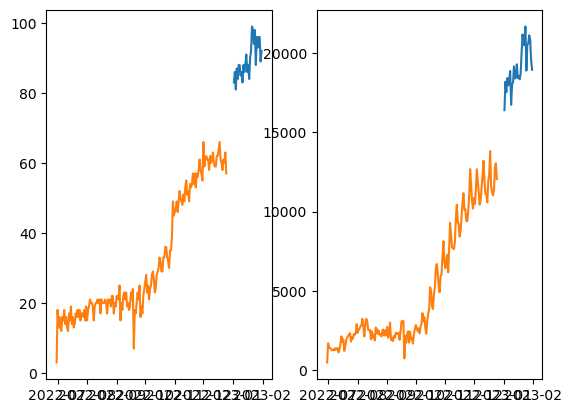

In [40]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(plot_forecast.agg("count"))
ax[0].plot(plot_actual.agg("count"))
ax[1].plot(plot_forecast.agg("sum"))
ax[1].plot(plot_actual.agg("sum"))


In [41]:
out_path = Path("/home/antoine/projects/forecasting/output")/"forecast.csv"
data_forecast_result[["UniqueID", "L Board Pax"]].reset_index().to_csv(out_path)
